### <font color='green'>1. Description<font>

Sentiment classification using Amazon review dataset (multi class classification).
Dataset can be downloaded from https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz

The consumer reviews serve as feedback for businesses in terms of performance, product quality, and consumer service. An online review typically consists of free-form text and a star rating out of 5. The problem of predicting a user’s star rating for a product, given the user’s text review for that product is lately become a popular, albeit hard, problem in machine learning. 
Using this dataset, we train a classifier to predict product rating based on the review text.

Predicting the ratings based on the text is particulary difficult tasks. The primary reason for the difficulty is that two person can provide different ratings for writing similar reviews. As the scale for ratings increases (scale of 5 to scale of 10), the tasks become increasingly difficult.

### <font color='green'>2. Data Preprocessing<font>

For amazon review classification we will perform some data preparation and data cleaning steps. We will generate word2vec embeddings for review text.

In [1]:
import os
import re
import time
import pandas as pd
import numpy as np
from collections import OrderedDict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
def clean_review(review):
    pattern = re.compile(r'[^a-zA-Z0-9 ]')
    review = pattern.sub(' ', review)
    return review

def document_vector_frovedis(doc, frov_w2v_model, frov_vocab):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    no_embedding = np.zeros(frov_w2v_model.shape[1])
    vocab_doc = [word for word in doc if word in frov_vocab]
    if len(vocab_doc) != 0:
        return list(np.mean(frov_w2v_model.loc[vocab_doc], axis=0))
    else:
        return list(no_embedding)

In [3]:
def create_w2v_embed(df):
    from frovedis.exrpc.server import FrovedisServer
    from frovedis.mllib.feature.w2v import Word2Vec as Frovedis_Word2Vec
    os.environ["VE_OMP_NUM_THREADS"] = '8'
    FrovedisServer.initialize("mpirun -np 1 " + os.environ["FROVEDIS_SERVER"])
    frovedis_w2v = Frovedis_Word2Vec(sentences = list(df["review_body"]), hiddenSize=512, minCount=2, n_iter=100)
    x_emb = frovedis_w2v.transform(list(df["review_body"]), func = np.mean)
    os.environ["VE_OMP_NUM_THREADS"] = '1'
    FrovedisServer.shut_down()
    return pd.DataFrame(x_emb)

In [4]:
def preprocess_data(fname):
    df = pd.read_csv(fname, sep='\t', error_bad_lines=False)
    print(df.shape)
    df = df[["review_body", "star_rating"]]
    df = df.dropna().drop_duplicates().sample(frac=1, random_state=42)
    df['review_body'] = df['review_body'].str.lower().apply(clean_review)
    print("Dataset contains {} reviews".format(df.shape[0]))
    rating_categories = df["star_rating"].value_counts()
    stop = stopwords.words('english')
    df['review_body'] = df['review_body'].apply(lambda x: [item for item in word_tokenize(x) if item not in stop])
    x = create_w2v_embed(df)
    x_train, x_test, y_train, y_test = train_test_split(x, df["star_rating"], random_state=42)
    return x_train, x_test, y_train, y_test, rating_categories

In [5]:
#---- Data Preparation ----
# Please uncomment the below lines to download and unzip the dataset.
#!wget -N https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz
#!gunzip amazon_reviews_us_Books_v1_02.tsv.gz
#!mv amazon_reviews_us_Books_v1_02.tsv datasets

DATA_FILE = "datasets/amazon_reviews_us_Books_v1_02.tsv/amazon_reviews_us_Books_v1_02.tsv"
x_train, x_test, y_train, y_test, rating_categories = preprocess_data(DATA_FILE)
print("shape of train data: {}".format(x_train.shape))
print("shape of test data: {}".format(x_test.shape))

b'Skipping line 1680001: expected 15 fields, saw 22\n'


(3105370, 15)
Dataset contains 3071369 reviews
shape of train data: (2303526, 512)
shape of test data: (767843, 512)


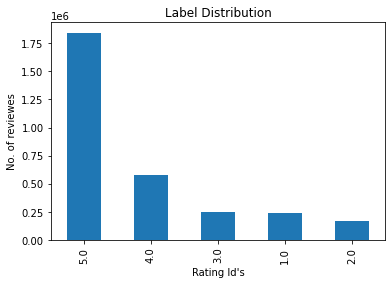

In [6]:
# Label distribution summary
ax = rating_categories.plot(kind='bar', title='Label Distribution').\
     set(xlabel="Rating Id's", ylabel="No. of reviewes")

### <font color='green'> 3. Algorithm Evaluation<font>

In [7]:
train_time = []
test_time = []
accuracy = []
precision = []
recall = []
f1 = []
estimator_name = []

In [8]:
def evaluate(estimator, estimator_nm,
             x_train, y_train,
             x_test, y_test):
    estimator_name.append(estimator_nm)

    start_time = time.time()
    estimator.fit(x_train, y_train)
    train_time.append(round(time.time() - start_time, 4))

    start_time = time.time()
    pred_y = estimator.predict(x_test)
    test_time.append(round(time.time() - start_time, 4))

    accuracy.append(metrics.accuracy_score(y_test, pred_y))
    precision.append(metrics.precision_score(y_test, pred_y, average='macro'))
    recall.append(metrics.recall_score(y_test, pred_y, average='macro'))
    f1.append(metrics.f1_score(y_test, pred_y, average='macro'))

    target_names = ['rating 1.0', 'rating 2.0', 'rating 3.0', 'rating 4.0', 'rating 5.0']
    return metrics.classification_report(y_test, pred_y, target_names=target_names)

#### 3.1 Bernoulli Naive Bayes

In [9]:
# Demo: Bernoulli Naive Bayes
import frovedis
TARGET = "bernoulli_naive_bayes"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.naive_bayes import BernoulliNB as frovNB

f_est = frovNB(alpha=1.0)
E_NM = TARGET + "_frovedis_" + frovedis.__version__
f_report = evaluate(f_est, E_NM, \
                    x_train, y_train, x_test, y_test)
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.naive_bayes import BernoulliNB as skNB
s_est = skNB(alpha=1.0)
E_NM = TARGET + "_sklearn_" + sklearn.__version__
s_report = evaluate(s_est, E_NM, \
                    x_train, y_train, x_test, y_test)
# Precision, Recall and F1 score for each class
print("Frovedis Bernoulli Naive Bayes metrices: ")
print(f_report)
print("Sklearn Bernoulli Naive Bayes metrices: ")
print(s_report)

Frovedis Bernoulli Naive Bayes metrices: 
              precision    recall  f1-score   support

  rating 1.0       0.34      0.49      0.40     59017
  rating 2.0       0.17      0.31      0.22     41354
  rating 3.0       0.20      0.22      0.21     61591
  rating 4.0       0.28      0.31      0.30    144753
  rating 5.0       0.78      0.65      0.71    461128

    accuracy                           0.52    767843
   macro avg       0.35      0.39      0.37    767843
weighted avg       0.57      0.52      0.54    767843

Sklearn Bernoulli Naive Bayes metrices: 
              precision    recall  f1-score   support

  rating 1.0       0.34      0.49      0.40     59017
  rating 2.0       0.17      0.31      0.22     41354
  rating 3.0       0.20      0.22      0.21     61591
  rating 4.0       0.28      0.31      0.30    144753
  rating 5.0       0.78      0.65      0.71    461128

    accuracy                           0.52    767843
   macro avg       0.35      0.39      0.37    7

#### 3.2 Decision Tree

In [10]:
# Demo: DecisionTreeClassifier
import frovedis
TARGET = "decision_tree"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.tree import DecisionTreeClassifier as frovDecisionTreeClassifier

f_est = frovDecisionTreeClassifier(max_leaf_nodes=5, max_depth=12)
E_NM = TARGET + "_frovedis_" + frovedis.__version__
f_report = evaluate(f_est, E_NM, \
                    x_train, y_train, x_test, y_test)
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.tree import DecisionTreeClassifier as skDecisionTreeClassifier
s_est = skDecisionTreeClassifier(max_leaf_nodes=5, max_depth=12)
E_NM = TARGET + "_sklearn_" + sklearn.__version__
s_report = evaluate(s_est, E_NM, \
                    x_train, y_train, x_test, y_test)

# Precision, Recall and F1 score for each class
print("Frovedis Decision Tree metrices: ")
print(f_report)
print("Sklearn Decision Tree metrices: ")
print(s_report)

/home/adityaw/virt1/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adityaw/virt1/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adityaw/virt1/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Frovedis Decision Tree metrices: 
              precision    recall  f1-score   support

  rating 1.0       0.37      0.27      0.31     59017
  rating 2.0       0.22      0.01      0.01     41354
  rating 3.0       0.23      0.04      0.07     61591
  rating 4.0       0.26      0.03      0.06    144753
  rating 5.0       0.64      0.96      0.77    461128

    accuracy                           0.61    767843
   macro avg       0.34      0.26      0.24    767843
weighted avg       0.49      0.61      0.50    767843

Sklearn Decision Tree metrices: 
              precision    recall  f1-score   support

  rating 1.0       0.00      0.00      0.00     59017
  rating 2.0       0.00      0.00      0.00     41354
  rating 3.0       0.00      0.00      0.00     61591
  rating 4.0       0.00      0.00      0.00    144753
  rating 5.0       0.60      1.00      0.75    461128

    accuracy                           0.60    767843
   macro avg       0.12      0.20      0.15    767843
weighted a

/home/adityaw/virt1/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### <font color='green'> 4. Performance summary<font>

In [11]:
summary = pd.DataFrame(OrderedDict({ "estimator": estimator_name,
                                     "train time": train_time,
                                     "test time": test_time,
                                     "accuracy": accuracy,
                                     "precision": precision,
                                     "recall": recall,
                                     "f1-score": f1
                                  }))
summary

,estimator,train time,test time,accuracy,precision,recall,f1-score
0,bernoulli_naive_bayes_frovedis_0.9.10,3.8471,2.5516,0.518564,0.354237,0.394694,0.366431
1,bernoulli_naive_bayes_sklearn_0.24.1,19.9974,6.7362,0.518564,0.354237,0.394694,0.366431
2,decision_tree_frovedis_0.9.10,35.7016,3.6518,0.609019,0.344660,0.261983,0.243691
3,decision_tree_sklearn_0.24.1,730.6046,1.5582,0.600550,0.120110,0.200000,0.150086
